In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from itertools import cycle
from sklearn.preprocessing import LabelEncoder

### Initial Analysis of Calendar File

In [2]:
# Read in Calendar file
df_calendar = pd.read_csv('/Users/ianforrest/Downloads/m5-forecasting-accuracy/calendar.csv')

# convert NaN values to 'None'; NaN values only contained in event_name_# & event_type_#, where NaN represents 'None'
df_calendar = df_calendar.fillna('None')

# create list of all unique event_names in dataset
event_name_list = set(df_calendar['event_name_1'].unique().tolist() + df_calendar['event_name_2'].unique().tolist())
event_name_list = list(event_name_list)
# convert to dictionary
event_name_dict = {ni: indi for indi, ni in enumerate(set(event_name_list))}
# adjust value of 'None' to be uniform across all 'name' & 'type' columns
event_name_dict['None'] = 0
event_name_dict['LentStart'] = 18
# map to dataframe
df_calendar['event_name_1'] = df_calendar['event_name_1'].map(event_name_dict)
df_calendar['event_name_2'] = df_calendar['event_name_2'].map(event_name_dict)

# create list of all unique event_types in dataset
event_type_list = set(df_calendar['event_type_1'].unique().tolist() + df_calendar['event_type_2'].unique().tolist())
event_type_list = list(event_type_list)
# convert to dictionary
event_type_dict = {ni: indi for indi, ni in enumerate(set(event_type_list))}
# adjust value of 'None' to be uniform across all 'name' & 'type' columns
event_type_dict['None'] = 0
event_type_dict['National'] = 1
# map to dataframe
df_calendar['event_type_1'] = df_calendar['event_type_1'].map(event_type_dict)
df_calendar['event_type_2'] = df_calendar['event_type_2'].map(event_type_dict)

# adjust 'd' column, change name to 'day_total'
df_calendar = df_calendar.rename(columns={"d": "day_total", "wday":"day_of_wk"})
df_calendar['day_total'] = df_calendar['day_total']

# convert category columns to 'category' dtype
category_columns = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'weekday', 'day_of_wk']
for column in category_columns:
    df_calendar[column] = df_calendar[column].astype('category')

# convert 'date' column to datetime
df_calendar['date'] = pd.to_datetime(df_calendar['date'])
# add 'day_of_month' column
df_calendar['day_of_month'] = df_calendar['date'].map(lambda x: x.day)
# create custom data dictionary for day_of_wk column columns
day_dict = {'Sunday':1, 'Monday':2, 'Tuesday':3, 'Wednesday':4,
            'Thursday':5, 'Friday':6, 'Saturday':7}
# map to dataframe
df_calendar['day_of_wk'] = df_calendar['weekday'].map(day_dict)
# drop 'weekday' column, now contains redundant information
df_calendar = df_calendar.drop(columns = ['weekday'])

# rearrange columns
df_calendar = df_calendar[['date', 'wm_yr_wk', 'day_of_wk', 'day_of_month',
                           'month', 'year', 'day_total', 'event_name_1', 'event_type_1', 'event_name_2',
                           'event_type_2','snap_CA', 'snap_TX', 'snap_WI']]

df_calendar.head()

,date,wm_yr_wk,day_of_wk,day_of_month,month,year,day_total,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,7,29,1,2011,d_1,0,0,0,0,0,0,0
1,2011-01-30,11101,1,30,1,2011,d_2,0,0,0,0,0,0,0
2,2011-01-31,11101,2,31,1,2011,d_3,0,0,0,0,0,0,0
3,2011-02-01,11101,3,1,2,2011,d_4,0,0,0,0,1,1,0
4,2011-02-02,11101,4,2,2,2011,d_5,0,0,0,0,1,0,1


In [3]:
df_calendar.dtypes

date            datetime64[ns]
wm_yr_wk                 int64
day_of_wk                int64
day_of_month             int64
month                    int64
year                     int64
day_total               object
event_name_1          category
event_type_1          category
event_name_2          category
event_type_2          category
snap_CA                  int64
snap_TX                  int64
snap_WI                  int64
dtype: object

In [4]:
df_calendar.shape

(1969, 14)

In [8]:
df_calendar.tail()

,date,wm_yr_wk,day_of_wk,day_of_month,month,year,day_total,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
1964,2016-06-15,11620,4,15,6,2016,d_1965,0,0,0,0,0,1,1
1965,2016-06-16,11620,5,16,6,2016,d_1966,0,0,0,0,0,0,0
1966,2016-06-17,11620,6,17,6,2016,d_1967,0,0,0,0,0,0,0
1967,2016-06-18,11621,7,18,6,2016,d_1968,0,0,0,0,0,0,0
1968,2016-06-19,11621,1,19,6,2016,d_1969,22,4,7,2,0,0,0


### Initial Analysis of Sales_Train_Val File
- may have to drop last 56 rows from df_calendar
- df_calendar accounts for 1969 days, while df_sales_train_val only accounts for 1913 days
- need to be uniform for merge

In [19]:
# define categories
numcols = [f"d_{day}" for day in range(1,1914)]
catcols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
dtype = {numcol:"float32" for numcol in numcols} 
dtype.update({col: "category" for col in catcols if col != "id"})

# read in csv
df_sales_train_val = pd.read_csv('/Users/ianforrest/Downloads/m5-forecasting-accuracy/sales_train_validation.csv', 
                                usecols = catcols + numcols, dtype = dtype)
df_sales_train_val.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0.0,0.0,0.0,0.0,...,1.0,3.0,0.0,1.0,1.0,1.0,3.0,0.0,1.0,1.0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0.0,0.0,0.0,0.0,...,2.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,4.0,1.0,0.0,1.0,3.0,7.0,2.0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0.0,0.0,0.0,0.0,...,2.0,1.0,1.0,0.0,1.0,1.0,2.0,2.0,2.0,4.0


In [20]:
# extend d_#### to match calendar file
for day in range(1914, 1970):
    df_sales_train_val[f"d_{day}"] = np.nan
    
df_sales_train_val.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1960,d_1961,d_1962,d_1963,d_1964,d_1965,d_1966,d_1967,d_1968,d_1969
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
for col in catcols:
    if col != "id":
        df_sales_train_val[col] = df_sales_train_val[col].cat.codes.astype("int16")
        df_sales_train_val[col] -= df_sales_train_val[col].min()

In [24]:
df_sales_train_val.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1960,d_1961,d_1962,d_1963,d_1964,d_1965,d_1966,d_1967,d_1968,d_1969
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HOBBIES_1_003_CA_1_validation,2,0,0,0,0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HOBBIES_1_004_CA_1_validation,3,0,0,0,0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HOBBIES_1_005_CA_1_validation,4,0,0,0,0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_sales_train_val = pd.melt(df_sales_train_val, id_vars = catcols, value_vars = [col for col in df_sales_train_val.columns if col.startswith("d_")],
             var_name = "d", value_name = "sales")

In [22]:
df_sales_train_val.dtypes


id            object
item_id     category
dept_id     category
cat_id      category
store_id    category
state_id    category
d_1          float32
d_2          float32
d_3          float32
d_4          float32
d_5          float32
d_6          float32
d_7          float32
d_8          float32
d_9          float32
d_10         float32
d_11         float32
d_12         float32
d_13         float32
d_14         float32
d_15         float32
d_16         float32
d_17         float32
d_18         float32
d_19         float32
d_20         float32
d_21         float32
d_22         float32
d_23         float32
d_24         float32
              ...   
d_1940       float64
d_1941       float64
d_1942       float64
d_1943       float64
d_1944       float64
d_1945       float64
d_1946       float64
d_1947       float64
d_1948       float64
d_1949       float64
d_1950       float64
d_1951       float64
d_1952       float64
d_1953       float64
d_1954       float64
d_1955       float64
d_1956       

In [6]:
# create sample subset to view sales history of 20 random items
# units sold per day for 20 items, for 5 years
d_cols = [c for c in df_sales_train_val.columns if 'd_' in c]

twenty_examples = df_sales_train_val.sample(20, random_state=43243) \
        .set_index('id')[d_cols] \
    .T \
    .merge(df_calendar.set_index('day_total')['date'],
           left_index=True,
           right_index=True,
            validate='1:1') \
    .set_index('date')

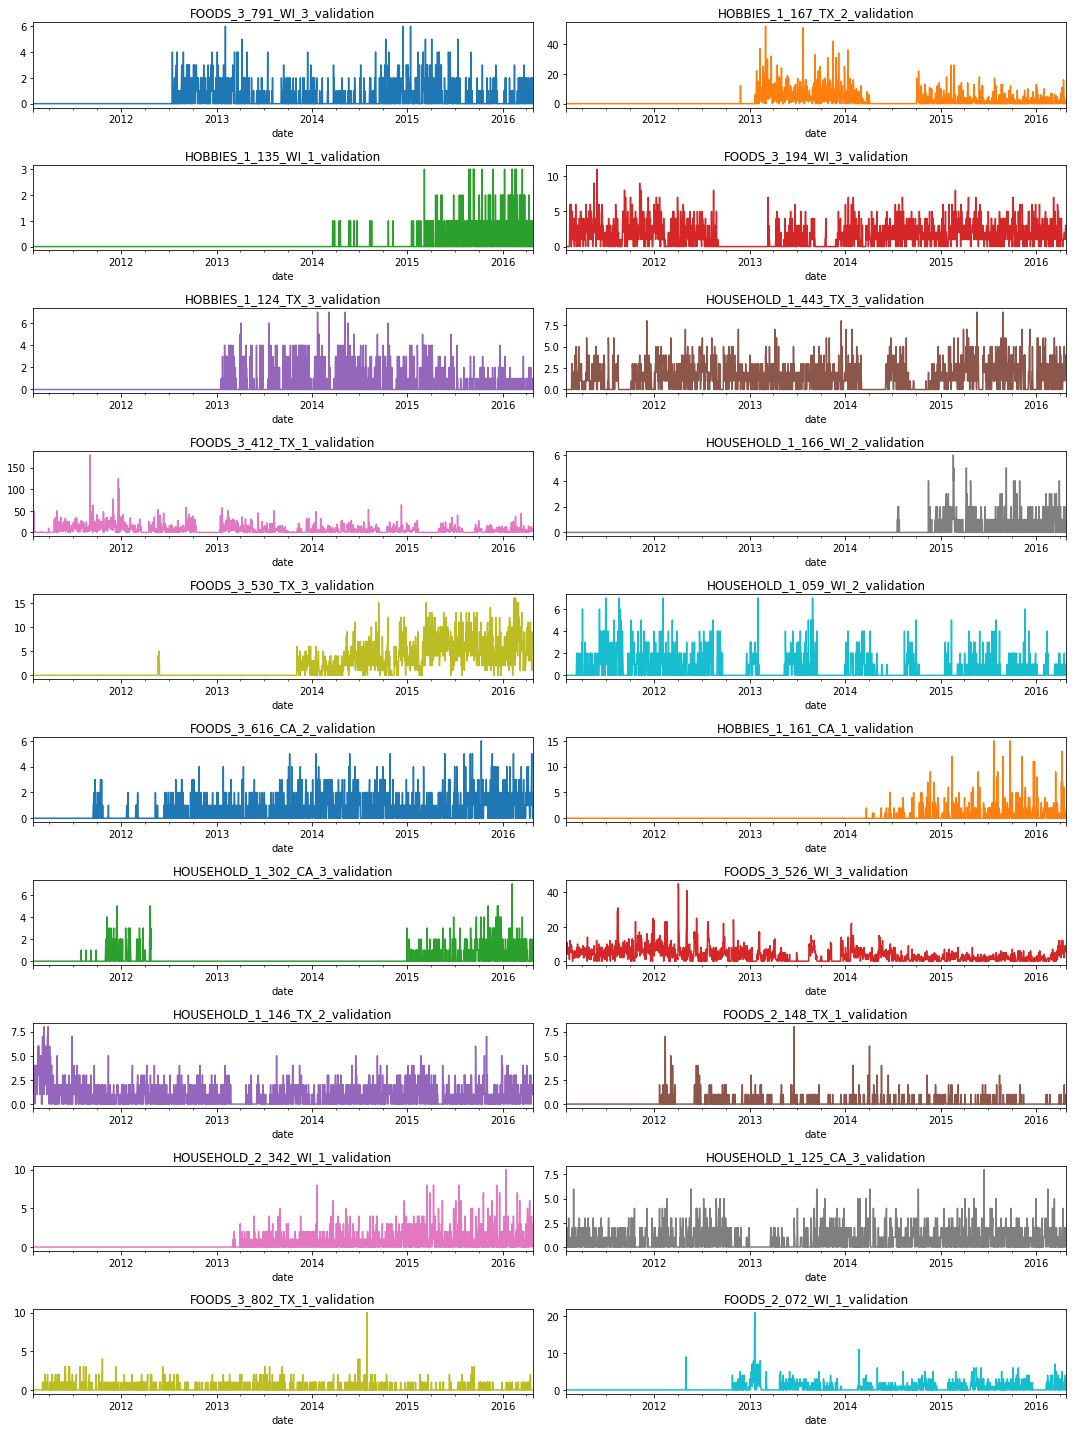

In [7]:
# probably don't want to start at day 1; seems some products did not exist in beginning of dataset
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

fig, axs = plt.subplots(10, 2, figsize=(15, 20))
axs = axs.flatten()
ax_idx = 0
for item in twenty_examples.columns:
    twenty_examples[item].plot(title=item,
                              color=next(color_cycle),
                              ax=axs[ax_idx])
    ax_idx += 1
plt.tight_layout()
plt.show()

In [171]:
df_sales_train_val.shape

(30490, 1919)

#### Initial Analysis of Sample Submission

In [11]:
df_sample_sub = pd.read_csv('/Users/ianforrest/Downloads/m5-forecasting-accuracy/sample_submission.csv')
df_sample_sub.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
df_sample_sub.shape

(60980, 29)

#### Initial Analysis of Sell Prices

In [15]:
df_sell_prices = pd.read_csv('/Users/ianforrest/Downloads/m5-forecasting-accuracy/sell_prices.csv')
df_sell_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [16]:
df_sell_prices.dtypes

store_id       object
item_id        object
wm_yr_wk        int64
sell_price    float64
dtype: object

In [ ]:
{"store_id": "category", "item_id": "category", "wm_yr_wk": "int16","sell_price":"float32" }